In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score # métrica de evaluación
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder 

import sys
sys.path.append('../Code')
from sklearn import metrics
from CustomTransformers import CollinearityDropper

# Análisis Exploratorio

In [36]:
df_nasa = pd.read_csv('https://raw.githubusercontent.com/pokengineer/DataScience/main/datasets/asteroids_nasa.csv')
df_nasa.head(5)


,Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),...,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Equinox,Hazardous
0,3703080,3703080,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,...,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,J2000,True
1,3723955,3723955,21.3,0.146068,0.326618,146.067964,326.617897,0.090762,0.202951,479.225620,...,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,J2000,False
2,2446862,2446862,20.3,0.231502,0.517654,231.502122,517.654482,0.143849,0.321655,759.521423,...,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,J2000,True
3,3092506,3092506,27.4,0.008801,0.019681,8.801465,19.680675,0.005469,0.012229,28.876199,...,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,J2000,False
4,3514799,3514799,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,...,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,J2000,True


In [37]:
df_nasa[["Est Dia in KM(min)", "Est Dia in KM(max)", "Absolute Magnitude"]].corr(method='pearson')

,Est Dia in KM(min),Est Dia in KM(max),Absolute Magnitude
Est Dia in KM(min),1.000000,1.000000,-0.613482
Est Dia in KM(max),1.000000,1.000000,-0.613482
Absolute Magnitude,-0.613482,-0.613482,1.000000


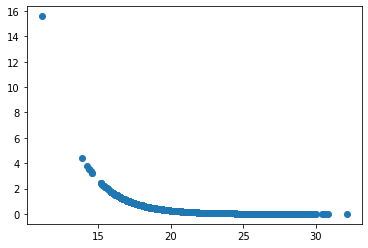

In [38]:
#=> magnitud absoluta es brillo (escala logaritmica) 
plt.plot(df_nasa["Absolute Magnitude"], df_nasa["Est Dia in KM(min)"], 'o')

In [39]:
df_nasa[["Est Dia in KM(min)", "Est Dia in KM(max)", "Absolute Magnitude"]].corr(method='kendall')

,Est Dia in KM(min),Est Dia in KM(max),Absolute Magnitude
Est Dia in KM(min),1.0,1.0,-1.0
Est Dia in KM(max),1.0,1.0,-1.0
Absolute Magnitude,-1.0,-1.0,1.0


In [40]:
df_nasa.shape

(4687, 40)

In [41]:
df_nasa.drop(['Orbiting Body','Equinox'],axis=1, inplace=True)

In [42]:
pfd = CollinearityDropper(columns=df_nasa.select_dtypes(include=['int', 'float']).columns, min_coef=0.9)
pfd.fit(df_nasa)
df = pfd.transform(df_nasa)
#df_nasa[df_nasa.select_dtypes(include=['int', 'float']).columns].corr()
df.shape

(4687, 20)

# Seleccionamos las variables que vamos a utilizar y hacemos el Split

In [43]:
df = df.drop(['Close Approach Date','Orbit Determination Date'],axis=1)
X = df.drop("Hazardous",axis=1)
y = df["Hazardous"]


In [44]:
# Hacemos el Split 70-30 para train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=0)

In [45]:
# Creamos y entrenamos modelo
treeclf = DecisionTreeClassifier(max_depth=3, random_state=1) # maxima profundidad = 3
treeclf.fit(X_train, y_train) # entrenamos el árbol

DecisionTreeClassifier(max_depth=3, random_state=1)

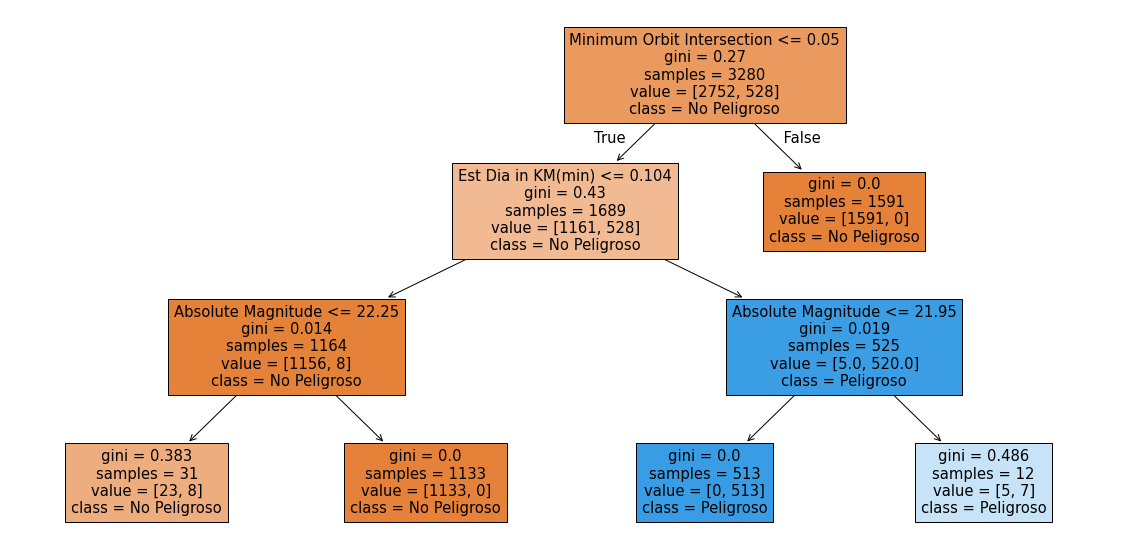

'\n# Visualizamos el árbol generado usando graphviz\ndot_data = export_graphviz(treeclf, out_file=None,\n                feature_names=X.columns,\n                filled=True, rounded=True,\n                special_characters=True)\ngraph = pydotplus.graph_from_dot_data(dot_data)\nImage(graph.create_png())\n'

In [50]:
# Importamos la librería que necesitamos
plt.figure(figsize=(20,10))
plot_tree(treeclf, feature_names=X.columns,  class_names=["No Peligroso", "Peligroso"], filled=True)
plt.show()

In [25]:
y_pred_tc = treeclf.predict(X_test)

#Exactitud del modelo
print('Exactitud (accuracy) del modelo: {:.2f} %'.format(accuracy_score(y_test, y_pred_tc)*100))
print("-"*100)

# Reporte del clasificador
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_tc))

Exactitud (accuracy) del modelo: 99.36 %
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1180
        True       0.98      0.98      0.98       227

    accuracy                           0.99      1407
   macro avg       0.99      0.99      0.99      1407
weighted avg       0.99      0.99      0.99      1407



Aca se muestra que con KNN se pueden alcanzar resultados similares a arboles. La ventaja de los arboles, fueron mucho mas robustos, no me pidieron nada, con KNN tuve que realizar un preproceso mas a conciencia.

In [31]:
X_train

,Neo Reference ID,Absolute Magnitude,Est Dia in KM(min),Epoch Date Close Approach,Relative Velocity km per sec,Miss Dist.(Astronomical),Orbit ID,Orbit Uncertainity,Minimum Orbit Intersection,Jupiter Tisserand Invariant,Epoch Osculation,Eccentricity,Inclination,Asc Node Longitude,Perihelion Distance,Perihelion Arg,Mean Anomaly
733,2053409,18.7,0.483676,936774000000,14.355893,0.248705,32,0,0.086402,3.448,2458000.5,0.627974,10.871214,206.729281,0.781763,147.726051,323.255458
449,3552665,23.7,0.048368,882172800000,9.021259,0.105939,17,5,0.001826,4.756,2458000.5,0.306153,2.128786,63.829539,0.955886,333.623446,81.960397
675,2038071,19.6,0.319562,923554800000,9.754880,0.029457,50,0,0.034100,3.555,2458000.5,0.506925,12.730677,195.534070,1.030481,8.809067,33.843026
4542,3749026,26.7,0.012149,1460098800000,13.030799,0.011853,6,8,0.010528,3.433,2457481.5,0.589102,7.854573,193.851966,0.891085,50.153925,348.042248
3801,3550301,19.7,0.305179,1389772800000,2.812339,0.473800,29,0,0.315901,3.753,2457800.5,0.361699,7.150616,55.023435,1.274142,98.479427,11.568684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614,2162215,19.0,0.421265,911721600000,11.652833,0.353932,47,0,0.256574,5.594,2458000.5,0.436598,17.337310,202.345559,0.609354,346.764783,162.916727
529,2152680,19.4,0.350393,897289200000,20.114451,0.083219,28,0,0.005399,4.390,2458000.5,0.639783,10.930376,98.595390,0.521522,260.068078,345.613632
4343,3672464,24.4,0.035039,1442300400000,10.154380,0.227376,8,5,0.016004,6.491,2458000.5,0.376164,13.316227,233.919016,0.565727,228.017955,31.113842
2739,3477702,26.8,0.011603,1258272000000,25.339680,0.001762,7,9,0.000967,5.226,2455154.5,0.741454,2.776929,54.464899,0.292398,227.950223,41.197593


In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
param_grid = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21]}

ss = StandardScaler()
ss.fit(X_train)
gs = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid, scoring='accuracy', cv=5)
gs.fit(ss.transform(X_train), y_train)
y_pred_knn = gs.predict(ss.transform(X_test))


In [29]:
pl = Pipeline(steps=[('scaler', StandardScaler()), 
                     ('knn', GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid, scoring='accuracy', cv=5))])
pl.fit(X_train, y_train)
y_pred_knn = pl.predict(X_test)
print(classification_report(y_test,y_pred_knn))

              precision    recall  f1-score   support

       False       0.93      0.95      0.94      1180
        True       0.72      0.63      0.67       227

    accuracy                           0.90      1407
   macro avg       0.82      0.79      0.80      1407
weighted avg       0.90      0.90      0.90      1407



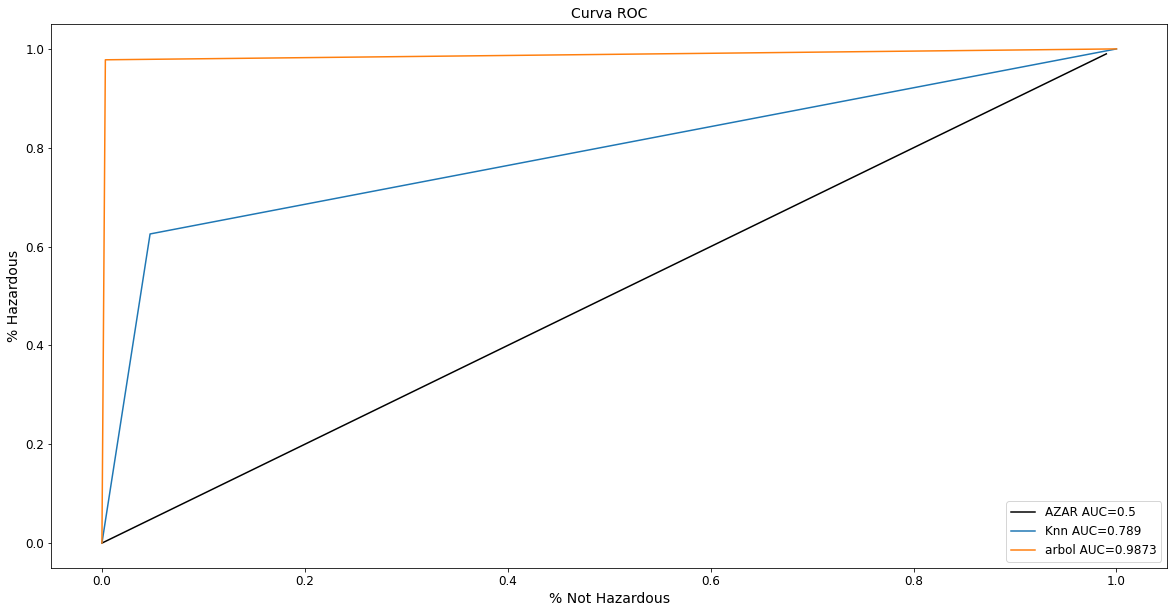

In [30]:
def graficarCurvaRoc( y_pred, model ):
  fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
  auc = metrics.roc_auc_score(y_test, y_pred)
  # Graficamos
  plt.plot(fpr,tpr,label= model +" AUC="+str(round(auc,4))) #,label= "AUC="+str(auc))
  plt.legend(loc=4, fontsize=12)
  return auc

# Inicializamos los labels del gráfico
plt.figure(figsize=(20, 10))
plt.xlabel('% Not Hazardous', fontsize=14)
plt.ylabel('% Hazardous', fontsize=14)

# Graficamos la recta del azar
it = [i/100 for i in range(100)]
plt.plot(it,it,label="AZAR AUC=0.5",color="black")

modelos = {'Knn':y_pred_knn, 'arbol':y_pred_tc }
for pred in modelos:
    auc = graficarCurvaRoc( modelos[pred] , pred )

# Agregamos el titulo y configuro el tamaño de letra
plt.title("Curva ROC", fontsize=14)
plt.tick_params(labelsize=12)
plt.show()